# Object Detection using Faster R-CNN 
### Group members


*   Ashutosh Chauhan (S20180010017)
*   Pradum Singh (S20180010136)
*   Vipul Rawat (S20180010192)
*   Ayush Gairola (S20180010020)



In [ ]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

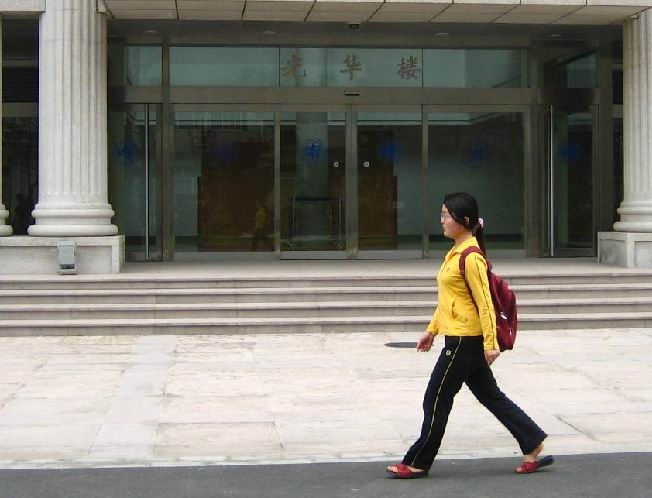

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00013.png')

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from pprint import pprint
from tqdm import tqdm
import torchvision.transforms as T
from PIL import Image

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        # load all image files, sorting them so they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load the images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are color coded differently
        obj_ids = np.unique(mask)
        # remove the first id because it is background
        obj_ids = obj_ids[1:]

        # split the color-encoded mask
        masks = mask == obj_ids[:, None, None]

        # getting the bounding box sizes for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area

        img = T.ToTensor()(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# use the dataset and defined transformations from the class
dataset = PennFudanDataset('PennFudanPed')
dataset_test = PennFudanDataset('PennFudanPed')

# spliting the dataset into training and testing datasets
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# here the testing and training data loaders are defined
train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# here we are using quickvision to get backend model which is Imagenet pretrained ResNet101
!pip install -q git+https://github.com/Quick-AI/quickvision.git


     |████████████████████████████████| 839kB 5.8MB/s 
     |████████████████████████████████| 25.9MB 116kB/s 
     |████████████████████████████████| 112kB 42.3MB/s 
     |████████████████████████████████| 829kB 40.3MB/s 
     |████████████████████████████████| 184kB 43.0MB/s 
     |████████████████████████████████| 276kB 40.6MB/s 
     |████████████████████████████████| 1.3MB 37.7MB/s 
     |████████████████████████████████| 143kB 39.5MB/s 
     |████████████████████████████████| 296kB 29.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
from quickvision.models.detection import faster_rcnn

In [ ]:
backbone = faster_rcnn.create_fastercnn_backbone("resnet101", fpn=True, pretrained="imagenet", trainable_backbone_layers=3)

Resnet FPN Backbones works only for imagenet weights


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
# this dataset has two classes person and background
num_classes = 2
model = faster_rcnn.create_fastercnn(num_classes=num_classes, backbone=backbone)

In [ ]:
from torch.cuda import amp

In [ ]:
scaler = amp.GradScaler()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# the learning rate scheduler decreases the learning rate 10 times every 3 epochs
# so that gradient diminishing problem does not occur
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# train model for 10 epochs
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    # train for one epoch, printing every 10 iterations
    train_metrics = faster_rcnn.train_step(model, train_loader, device="cuda", optimizer=optimizer, scheduler=lr_scheduler, log_interval=100, scaler=scaler)
    val_metrics = faster_rcnn.val_step(model, test_loader, device="cuda")
    print("Training Metrics: ")
    pprint(train_metrics)
    print("Validation metrics")
    pprint(val_metrics)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Batch Train Time: 2.644 (2.644)  
Batch Train Time: 2.633 (2.285)  
Time taken for Training step = 137.16002702713013 sec
Batch Validation Time: 0.534 (0.534)  


 10%|█         | 1/10 [02:48<25:16, 168.45s/it]

Batch Validation Time: 0.386 (0.447)  
Time taken for validation step = 22.42557668685913 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8406764179468155),
             ('loss_classifier', 0.12020866485933462),
             ('loss_box_reg', 0.021570858136207485),
             ('loss_objectness', 0.6752747525771459),
             ('loss_rpn_box_reg', 0.023622144498707105)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.672 (2.672)  
Batch Train Time: 2.224 (2.297)  
Time taken for Training step = 137.8918731212616 sec
Batch Validation Time: 0.527 (0.527)  


 20%|██        | 2/10 [05:28<22:08, 166.02s/it]

Batch Validation Time: 0.382 (0.447)  
Time taken for validation step = 22.4270236492157 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8186443040768305),
             ('loss_classifier', 0.09964087555805842),
             ('loss_box_reg', 0.021656173168836782),
             ('loss_objectness', 0.6737016995747884),
             ('loss_rpn_box_reg', 0.02364555141927364)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 3.099 (3.099)  
Batch Train Time: 2.715 (2.281)  
Time taken for Training step = 136.90158772468567 sec
Batch Validation Time: 0.576 (0.576)  


 30%|███       | 3/10 [08:08<19:08, 164.04s/it]

Batch Validation Time: 0.383 (0.449)  
Time taken for validation step = 22.49722647666931 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8180528432130814),
             ('loss_classifier', 0.09931368914743265),
             ('loss_box_reg', 0.02135032752460878),
             ('loss_objectness', 0.6737932562828064),
             ('loss_rpn_box_reg', 0.023595568619202822)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.780 (2.780)  
Batch Train Time: 2.238 (2.297)  
Time taken for Training step = 137.8759343624115 sec
Batch Validation Time: 0.582 (0.582)  


 40%|████      | 4/10 [10:48<16:17, 162.95s/it]

Batch Validation Time: 0.389 (0.449)  
Time taken for validation step = 22.495996475219727 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8185049394766489),
             ('loss_classifier', 0.09930652678012848),
             ('loss_box_reg', 0.021774701868222716),
             ('loss_objectness', 0.6737678001324335),
             ('loss_rpn_box_reg', 0.023655909575366726)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.872 (2.872)  
Batch Train Time: 1.935 (2.300)  
Time taken for Training step = 138.04370045661926 sec
Batch Validation Time: 0.525 (0.525)  


 50%|█████     | 5/10 [13:29<13:31, 162.21s/it]

Batch Validation Time: 0.382 (0.447)  
Time taken for validation step = 22.41023826599121 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8192237208286921),
             ('loss_classifier', 0.0992117751389742),
             ('loss_box_reg', 0.022736673148271318),
             ('loss_objectness', 0.6736204435427984),
             ('loss_rpn_box_reg', 0.023654830847711614)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.306 (2.306)  
Batch Train Time: 2.379 (2.285)  
Time taken for Training step = 137.1768958568573 sec
Batch Validation Time: 0.530 (0.530)  


 60%|██████    | 6/10 [16:08<10:45, 161.44s/it]

Batch Validation Time: 0.384 (0.447)  
Time taken for validation step = 22.426528692245483 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8182259609301885),
             ('loss_classifier', 0.0988085426390171),
             ('loss_box_reg', 0.021986749193699022),
             ('loss_objectness', 0.6737965563933055),
             ('loss_rpn_box_reg', 0.02363411133410409)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.486 (2.486)  
Batch Train Time: 2.387 (2.279)  
Time taken for Training step = 136.77805542945862 sec
Batch Validation Time: 0.519 (0.519)  


 70%|███████   | 7/10 [18:47<08:02, 160.77s/it]

Batch Validation Time: 0.388 (0.447)  
Time taken for validation step = 22.38834261894226 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8187038024266561),
             ('loss_classifier', 0.09876700217525164),
             ('loss_box_reg', 0.022474012685900865),
             ('loss_objectness', 0.6738152166207632),
             ('loss_rpn_box_reg', 0.023647567041916773)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.837 (2.837)  
Batch Train Time: 1.823 (2.294)  
Time taken for Training step = 137.6784474849701 sec
Batch Validation Time: 0.562 (0.562)  


 80%|████████  | 8/10 [21:28<05:21, 160.58s/it]

Batch Validation Time: 0.385 (0.448)  
Time taken for validation step = 22.445338249206543 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8175605595111847),
             ('loss_classifier', 0.09919075605769952),
             ('loss_box_reg', 0.02107133876270382),
             ('loss_objectness', 0.6737495849529902),
             ('loss_rpn_box_reg', 0.02354888409220924)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.740 (2.740)  
Batch Train Time: 2.318 (2.274)  
Time taken for Training step = 136.49579095840454 sec
Batch Validation Time: 0.533 (0.533)  


 90%|█████████ | 9/10 [24:07<02:40, 160.09s/it]

Batch Validation Time: 0.383 (0.447)  
Time taken for validation step = 22.39288020133972 sec
Training Metrics: 
OrderedDict([('total_loss', 0.819635753830274),
             ('loss_classifier', 0.09987809136509895),
             ('loss_box_reg', 0.022409071524937946),
             ('loss_objectness', 0.6738376577695211),
             ('loss_rpn_box_reg', 0.02351093228207901)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
Batch Train Time: 2.613 (2.613)  
Batch Train Time: 2.029 (2.313)  
Time taken for Training step = 138.86966562271118 sec
Batch Validation Time: 0.524 (0.524)  


100%|██████████| 10/10 [26:48<00:00, 160.84s/it]

Batch Validation Time: 0.383 (0.447)  
Time taken for validation step = 22.40791654586792 sec
Training Metrics: 
OrderedDict([('total_loss', 0.8182581732670466),
             ('loss_classifier', 0.09894406522313753),
             ('loss_box_reg', 0.022109659904769312),
             ('loss_objectness', 0.6736016035079956),
             ('loss_rpn_box_reg', 0.023602845795297374)])
Validation metrics
OrderedDict([('iou', tensor(0.3845, device='cuda:0')),
             ('giou', tensor(0.2972, device='cuda:0'))])
